In [56]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from PIL import Image

import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow

keras = tf.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.preprocessing import image as tfImage

from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import tensorflow.keras.backend as K


# https://github.com/tensorflow/tensorflow/issues/24828
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


/usr/local/lib/python3.6/dist-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [5]:
# Set up
# Done using: https://www.kaggle.com/arturgor/don-t-judge-a-book-by-its-cover-cnn

DF_PATH = '/data/Documents/coverTheBookLover/data/goodreads-best-books/'
IMAGES_PATH = '/data/Documents/coverTheBookLover/data/goodreads-best-books/images/images/'
IMAGE_WIDTH = 160
IMAGE_HEIGHT = 160
IMAGE_CHANNELS = 3

VAL_SIZE = 0.2
MAX_POOL_DIM = 2
KERNEL_SIZE = 3

batch_size = 64

# How to get reproducible results in keras-StackOverflow
# Seed value
# Apparently you may use different seed values at each stage
RANDOM_STATE = 23

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(RANDOM_STATE)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(RANDOM_STATE)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(RANDOM_STATE)

# 5. Image number to filepath
def get_image(file_name, 
              root = IMAGES_PATH, 
              extension = '.jpg', 
              resize = False,
              reduce_channels = False):
    """
    Converts an image number into the file path where the image is located, 
    opens the image, and returns the image as a numpy array.
    """
#     filename = "{}.jpg".format(row_id)
    file_path = os.path.join(root, str(file_name) + extension)
    img = Image.open(file_path)
    if resize == True:
        img = img.resize((IMAGE_WIDTH,IMAGE_HEIGHT))
#     img = skimage.transform.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT), 
#                                      mode='reflect')
    if reduce_channels == True:
        return np.array(img)[:,:,:IMAGE_CHANNELS]
    else:
        return np.array(img)

### DATA PREPROCESSING

In [6]:
books_df = pd.read_csv(DF_PATH + 'book_data.csv')
# image filename is connected to initial index in dataframe 
books_df['img_name'] = books_df.index
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54301 entries, 0 to 54300
Data columns (total 13 columns):
book_authors         54301 non-null object
book_desc            52970 non-null object
book_edition         5453 non-null object
book_format          52645 non-null object
book_isbn            41435 non-null object
book_pages           51779 non-null object
book_rating          54301 non-null float64
book_rating_count    54301 non-null int64
book_review_count    54301 non-null int64
book_title           54301 non-null object
genres               51059 non-null object
image_url            53618 non-null object
img_name             54301 non-null int64
dtypes: float64(1), int64(3), object(9)
memory usage: 5.4+ MB


#### Drop books withouth covers

In [7]:
books_df = books_df[books_df['image_url'].notnull()].reset_index(drop = True)
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53618 entries, 0 to 53617
Data columns (total 13 columns):
book_authors         53618 non-null object
book_desc            52536 non-null object
book_edition         5423 non-null object
book_format          52201 non-null object
book_isbn            41024 non-null object
book_pages           51391 non-null object
book_rating          53618 non-null float64
book_rating_count    53618 non-null int64
book_review_count    53618 non-null int64
book_title           53618 non-null object
genres               50679 non-null object
image_url            53618 non-null object
img_name             53618 non-null int64
dtypes: float64(1), int64(3), object(9)
memory usage: 5.3+ MB


In [8]:
random_check = books_df.sample(1, random_state = RANDOM_STATE).iloc[0]['img_name']
books_df.sample(1, random_state = RANDOM_STATE)

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url,img_name
408,Philip Pullman,"Lost in a new world, Lyra finds Will—a boy on ...",First American Edition,Hardcover,9.78068E+12,326 pages,4.12,299723,7163,The Subtle Knife,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1505766360l...,409


The image size is: (318, 472)


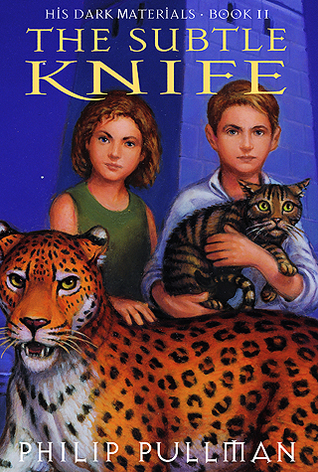

In [9]:
# Open the image
img = Image.open(IMAGES_PATH + str(random_check) + '.jpg') 

# Get the image size
print("The image size is: {}".format(img.size))

# Just having the image as the last line in the cell will display it in the notebook
img

In [10]:
# There is an error with couple images. Removing from analysis
img_error_list = ['2833', '17637', '33060', '44763', '49439']
books_sample_df = books_df[-books_df['img_name'].isin(img_error_list)]

The book ratings are not changed to classes as I want to use regression for rating prediction.

In [11]:
labels = books_sample_df[['img_name', 'book_rating']].set_index('img_name')
labels.head()

,book_rating
img_name,
0,4.33
1,4.48
2,4.27
3,4.25
4,3.58


#### Image standartization

In [12]:
labels1 = labels.copy().reset_index()
labels1['img_name'] = [IMAGES_PATH + str(i) + '.jpg' for i in labels1['img_name']]
labels1

,img_name,book_rating
0,/data/Documents/coverTheBookLover/data/goodrea...,4.33
1,/data/Documents/coverTheBookLover/data/goodrea...,4.48
2,/data/Documents/coverTheBookLover/data/goodrea...,4.27
3,/data/Documents/coverTheBookLover/data/goodrea...,4.25
4,/data/Documents/coverTheBookLover/data/goodrea...,3.58
...,...,...
53608,/data/Documents/coverTheBookLover/data/goodrea...,3.37
53609,/data/Documents/coverTheBookLover/data/goodrea...,3.97
53610,/data/Documents/coverTheBookLover/data/goodrea...,3.66
53611,/data/Documents/coverTheBookLover/data/goodrea...,3.82


In [13]:
valIndex = random.sample(range(len(labels1)), round(len(labels1)*VAL_SIZE))
trainIndex = [i for i in range(len(labels1)) if i not in valIndex]

train = labels1.iloc[trainIndex,]
validation = labels1.iloc[valIndex,]

In [14]:
train_image_generator = ImageDataGenerator(rescale=(1./127.5) - 1) # Generator for our training data
val_image_generator = ImageDataGenerator(rescale=(1./127.5) - 1) # Generator for our training data

In [15]:
train_data_gen = train_image_generator.flow_from_dataframe(
    train,
    x_col='img_name',
    y_col='book_rating',
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    class_mode='raw',
    batch_size=batch_size,
    seed=RANDOM_STATE
    )

val_data_gen = val_image_generator.flow_from_dataframe(
    validation,
    x_col='img_name',
    y_col='book_rating',
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    class_mode='raw',
    batch_size=batch_size,
    seed=RANDOM_STATE
    )

Found 42890 validated image filenames.
Found 10723 validated image filenames.


In [16]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [17]:
image_batch, label_batch = next(train_data_gen)
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 5, 5, 1280)


In [18]:
base_model.trainable = False
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [20]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1)


In [18]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [19]:
# trying to apply fast.ai collaborative filtering: https://course.fast.ai/videos/?lesson=4
# Lamda source: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda
def sigRating(x):
    max_rating = 5
    min_rating = 1
    
    sigX = tf.keras.backend.sigmoid(x)
    return sigX*(max_rating-min_rating)+min_rating
                                    

model.add(Lambda(sigRating))

In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='mse',
              metrics=['mae','mse'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
len(model.trainable_variables)

2

In [23]:
epochs = 15

In [24]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=len(train) // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=len(validation) // batch_size
)

Epoch 1/15
670/670 [==============================] - 198s 295ms/step - loss: 0.3491 - mae: 0.4578 - mse: 0.3491 - val_loss: 0.3149 - val_mae: 0.4431 - val_mse: 0.3149
Epoch 2/15
670/670 [==============================] - 198s 296ms/step - loss: 0.2233 - mae: 0.3635 - mse: 0.2233 - val_loss: 0.2942 - val_mae: 0.4281 - val_mse: 0.2942
Epoch 3/15
670/670 [==============================] - 195s 291ms/step - loss: 0.1899 - mae: 0.3317 - mse: 0.1899 - val_loss: 0.2653 - val_mae: 0.4023 - val_mse: 0.2653
Epoch 4/15
670/670 [==============================] - 195s 291ms/step - loss: 0.1702 - mae: 0.3103 - mse: 0.1701 - val_loss: 0.2212 - val_mae: 0.3592 - val_mse: 0.2212
Epoch 5/15
670/670 [==============================] - 195s 291ms/step - loss: 0.1577 - mae: 0.2967 - mse: 0.1576 - val_loss: 0.1998 - val_mae: 0.3372 - val_mse: 0.1998
Epoch 6/15
670/670 [==============================] - 196s 293ms/step - loss: 0.1481 - mae: 0.2864 - mse: 0.1482 - val_loss: 0.1654 - val_mae: 0.3001 - val_mse:

In [25]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
10,0.129545,0.262823,0.129545,0.144175,0.275642,0.144175,10
11,0.128225,0.261230,0.128225,0.143233,0.273652,0.143233,11
12,0.126019,0.259305,0.126020,0.142792,0.272717,0.142792,12
13,0.126919,0.258789,0.126919,0.139975,0.269710,0.139975,13
14,0.124795,0.257805,0.124795,0.142643,0.271940,0.142643,14


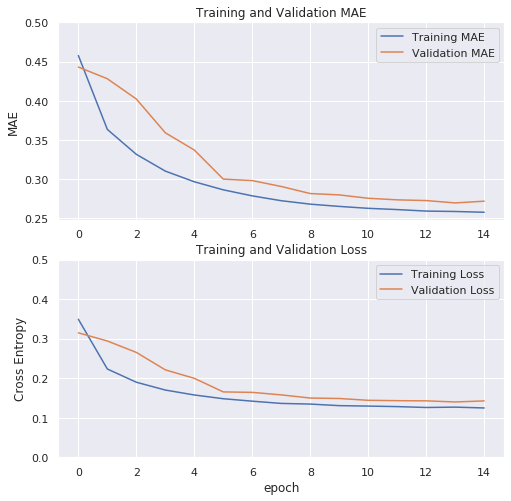

In [26]:
acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training MAE')
plt.plot(val_acc, label='Validation MAE')
plt.legend(loc='upper right')
plt.ylabel('MAE')
plt.ylim([min(plt.ylim()),0.5])
plt.title('Training and Validation MAE')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Unfreezing and training more layers

In [27]:
model.save('/data/Documents/coverTheBookLover/my_model.h5')

In [28]:
base_model.trainable = True

# Let's take a look to see how many layers are in ther base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [29]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              loss='mse',
              metrics=['mae','mse'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [31]:
len(model.trainable_variables)

58

In [33]:
# should solve RAM overflow issue
import gc

class MyCustomCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()

In [34]:
fine_tune_epochs = 10
total_epochs =  epochs + fine_tune_epochs

history_fine = model.fit_generator(train_data_gen,
                            steps_per_epoch=len(train) // batch_size,
                            epochs=total_epochs,
                            initial_epoch =  history.epoch[-1],
                            # initial_epoch =  epochs,
                            validation_data=val_data_gen,
                            validation_steps=len(validation) // batch_size,
                            callbacks=[MyCustomCallback()])  # should solve RAM issue

Epoch 15/25
670/670 [==============================] - 201s 300ms/step - loss: 0.1220 - mae: 0.2537 - mse: 0.1221 - val_loss: 0.1380 - val_mae: 0.2671 - val_mse: 0.1380
Epoch 16/25
670/670 [==============================] - 199s 297ms/step - loss: 0.1150 - mae: 0.2453 - mse: 0.1151 - val_loss: 0.1394 - val_mae: 0.2684 - val_mse: 0.1394
Epoch 17/25
670/670 [==============================] - 200s 298ms/step - loss: 0.1092 - mae: 0.2385 - mse: 0.1092 - val_loss: 0.1388 - val_mae: 0.2682 - val_mse: 0.1388
Epoch 18/25
670/670 [==============================] - 198s 295ms/step - loss: 0.1037 - mae: 0.2318 - mse: 0.1038 - val_loss: 0.1393 - val_mae: 0.2690 - val_mse: 0.1393
Epoch 19/25
670/670 [==============================] - 199s 297ms/step - loss: 0.0987 - mae: 0.2259 - mse: 0.0986 - val_loss: 0.1398 - val_mae: 0.2700 - val_mse: 0.1398
Epoch 20/25
670/670 [==============================] - 203s 304ms/step - loss: 0.0942 - mae: 0.2201 - mse: 0.0942 - val_loss: 0.1414 - val_mae: 0.2723 - va

In [35]:
acc += history_fine.history['mae']
val_acc += history_fine.history['val_mae']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

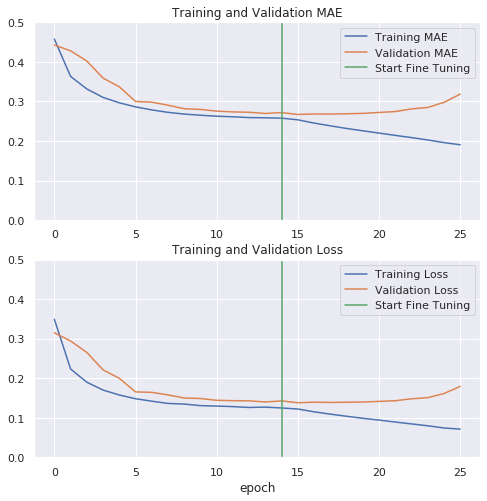

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training MAE')
plt.plot(val_acc, label='Validation MAE')
plt.ylim([0, 0.5])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation MAE')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, .5])
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

This one overtrained a bit, thus, I'll try to train it a bit more again but with reduced learning rate.

In [1]:
model.save('/data/Documents/coverTheBookLover/my_model_fitted2.h5')

NameError: name 'model' is not defined

### Retraining with lower lr from epoch=15

In [21]:
oldModel = tf.keras.models.load_model('my_model.h5')

In [22]:
oldModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
len(oldModel.trainable_variables)

2

In [24]:
oldModel.layers[0].summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [25]:
base_model = oldModel.layers[0]
base_learning_rate = 0.0001

base_model.trainable = True

# Let's take a look to see how many layers are in ther base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

oldModel.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/100),
              loss='mse',
              metrics=['mae','mse'])

Number of layers in the base model:  155


In [26]:
len(oldModel.trainable_variables)

58

In [28]:
fine_tune_epochs = 10
total_epochs = fine_tune_epochs

history_fine = oldModel.fit_generator(train_data_gen,
                            steps_per_epoch=len(train) // batch_size,
                            epochs=total_epochs,
#                             initial_epoch =  history.epoch[-1],
                            validation_data=val_data_gen,
                            validation_steps=len(validation) // batch_size,
#                             callbacks=[MyCustomCallback()] # should solve RAM issue
                                     )  

Epoch 1/10
670/670 [==============================] - 231s 345ms/step - loss: 0.1235 - mae: 0.2556 - mse: 0.1236 - val_loss: 0.1384 - val_mae: 0.2676 - val_mse: 0.1384
Epoch 2/10
670/670 [==============================] - 200s 299ms/step - loss: 0.1219 - mae: 0.2536 - mse: 0.1220 - val_loss: 0.1383 - val_mae: 0.2677 - val_mse: 0.1383
Epoch 3/10
670/670 [==============================] - 200s 298ms/step - loss: 0.1208 - mae: 0.2525 - mse: 0.1209 - val_loss: 0.1383 - val_mae: 0.2678 - val_mse: 0.1383
Epoch 4/10
670/670 [==============================] - 200s 299ms/step - loss: 0.1200 - mae: 0.2511 - mse: 0.1200 - val_loss: 0.1383 - val_mae: 0.2677 - val_mse: 0.1383
Epoch 5/10
670/670 [==============================] - 200s 298ms/step - loss: 0.1194 - mae: 0.2508 - mse: 0.1194 - val_loss: 0.1382 - val_mae: 0.2677 - val_mse: 0.1382
Epoch 6/10
670/670 [==============================] - 200s 299ms/step - loss: 0.1181 - mae: 0.2494 - mse: 0.1181 - val_loss: 0.1382 - val_mae: 0.2676 - val_mse:

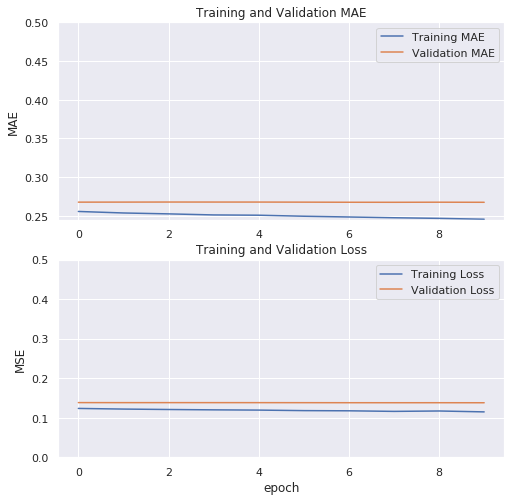

In [30]:
acc = history_fine.history['mae']
val_acc = history_fine.history['val_mae']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training MAE')
plt.plot(val_acc, label='Validation MAE')
plt.legend(loc='upper right')
plt.ylabel('MAE')
plt.ylim([min(plt.ylim()),0.5])
plt.title('Training and Validation MAE')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('MSE')
plt.ylim([0,.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Trying to train a bit more with a bit higher lr

In [31]:
oldModel.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/80),
              loss='mse',
              metrics=['mae','mse'])

In [32]:
fine_tune_epochs = 10
total_epochs += fine_tune_epochs

history_fine2 = oldModel.fit_generator(train_data_gen,
                            steps_per_epoch=len(train) // batch_size,
                            epochs=total_epochs,
                            initial_epoch =  history_fine.epoch[-1],
                            validation_data=val_data_gen,
                            validation_steps=len(validation) // batch_size,
#                             callbacks=[MyCustomCallback()] # should solve RAM issue
                                     )  

Epoch 10/20
670/670 [==============================] - 200s 298ms/step - loss: 0.1140 - mae: 0.2442 - mse: 0.1140 - val_loss: 0.1381 - val_mae: 0.2677 - val_mse: 0.1381
Epoch 11/20
670/670 [==============================] - 200s 299ms/step - loss: 0.1139 - mae: 0.2441 - mse: 0.1140 - val_loss: 0.1382 - val_mae: 0.2677 - val_mse: 0.1382
Epoch 12/20
670/670 [==============================] - 201s 300ms/step - loss: 0.1126 - mae: 0.2428 - mse: 0.1127 - val_loss: 0.1382 - val_mae: 0.2678 - val_mse: 0.1382
Epoch 13/20
670/670 [==============================] - 201s 301ms/step - loss: 0.1118 - mae: 0.2420 - mse: 0.1118 - val_loss: 0.1383 - val_mae: 0.2679 - val_mse: 0.1383
Epoch 14/20
670/670 [==============================] - 200s 299ms/step - loss: 0.1114 - mae: 0.2411 - mse: 0.1114 - val_loss: 0.1383 - val_mae: 0.2680 - val_mse: 0.1383
Epoch 15/20
670/670 [==============================] - 201s 299ms/step - loss: 0.1110 - mae: 0.2405 - mse: 0.1111 - val_loss: 0.1384 - val_mae: 0.2682 - va

Still not helping. Let's check predictions.

In [28]:
predictionsCheck = oldModel.predict(val_data_gen)

(array([3.000e+00, 7.300e+01, 7.500e+02, 2.317e+03, 3.410e+03, 2.672e+03,
        1.148e+03, 2.780e+02, 5.600e+01, 1.600e+01]),
 array([3.6198673, 3.716679 , 3.813491 , 3.9103029, 4.007115 , 4.1039267,
        4.2007384, 4.29755  , 4.3943624, 4.491174 , 4.587986 ],
       dtype=float32),
 <a list of 10 Patch objects>)

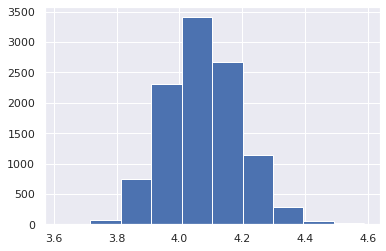

In [29]:
plt.hist(predictionsCheck)

(array([  68.,  188.,  583., 1533., 2586., 2854., 1807.,  651.,  208.,
         183.]),
 array([3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ]),
 <a list of 10 Patch objects>)

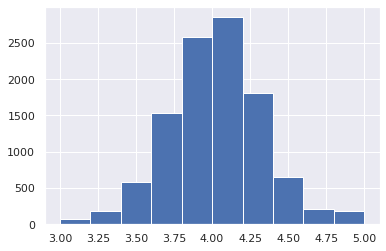

In [30]:
plt.hist(validation['book_rating'], range=(3,5))

Text(0.5, 1.0, 'Rating comparison')

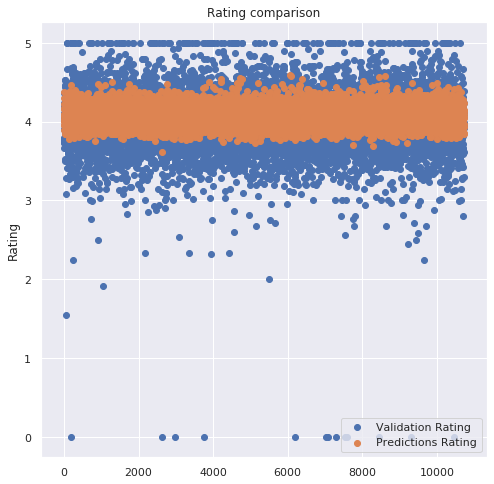

In [31]:
plt.figure(figsize=(8, 8))
plt.scatter(x=[i for i in range(len(predictionsCheck))], y=validation['book_rating'], label='Validation Rating')
plt.scatter(x=[i for i in range(len(predictionsCheck))],y=predictionsCheck, label='Predictions Rating')
plt.legend(loc='lower right')
plt.ylabel('Rating')
plt.title('Rating comparison')

A short conclusion would be it never gets to beat the mean model.

In [32]:
maxPred = predictionsCheck.tolist().index(max(predictionsCheck))
maxPred

6061

In [33]:
predictionsCheck.tolist()[maxPred-5:maxPred+5]

[[4.208802223205566],
 [4.172667503356934],
 [3.8938357830047607],
 [3.916142463684082],
 [4.002667427062988],
 [4.587985992431641],
 [3.978844404220581],
 [4.004459857940674],
 [4.207920074462891],
 [4.052206993103027]]

In [34]:
validation.head()

,img_name,book_rating
51077,/data/Documents/coverTheBookLover/data/goodrea...,3.79
18999,/data/Documents/coverTheBookLover/data/goodrea...,3.79
5475,/data/Documents/coverTheBookLover/data/goodrea...,4.08
1119,/data/Documents/coverTheBookLover/data/goodrea...,4.02
38799,/data/Documents/coverTheBookLover/data/goodrea...,4.11


In [35]:
bestCoverEvah = validation.reset_index().iloc[maxPred,:]
bestCoverEvah

index                                                      12436
img_name       /data/Documents/coverTheBookLover/data/goodrea...
book_rating                                                 3.76
Name: 6061, dtype: object

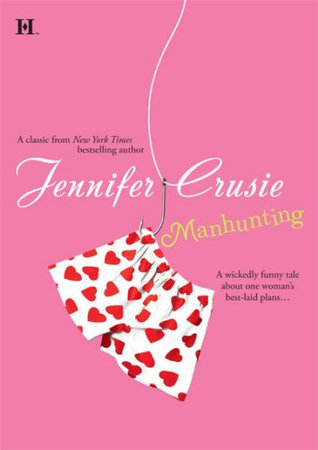

In [36]:
img = Image.open(bestCoverEvah[1])
img

In [37]:
ORIGINAL = bestCoverEvah[1]

DIM = IMAGE_HEIGHT

img = tfImage.load_img(ORIGINAL, target_size=(DIM, DIM))

x = tfImage.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [38]:
oldModel.layers[0].summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [59]:
with tf.GradientTape() as tape:
  last_conv_layer = oldModel.layers[0].layers[-3]
  iterate = tf.keras.models.Model([oldModel.layers[0].layers[0].input], [oldModel.layers[0].layers[-1].output, last_conv_layer.output])
  model_out, last_conv_layer = iterate(x)
  class_out = model_out[:, :]
  grads = tape.gradient(class_out, last_conv_layer)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

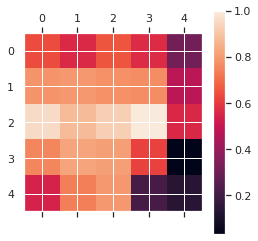

In [60]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = heatmap.reshape((5, 5))
plt.matshow(heatmap)
plt.colorbar()
plt.show()

In [61]:
img = cv2.imread(ORIGINAL)

INTENSITY = 0.8

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

img = heatmap * INTENSITY + img

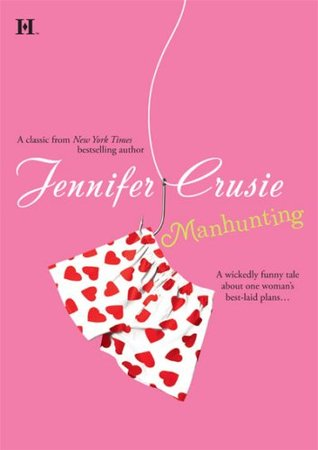

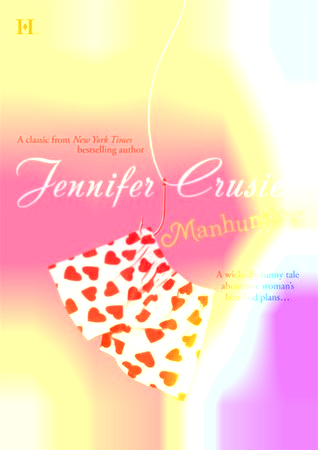

In [62]:
cv2_imshow(cv2.imread(ORIGINAL))
cv2_imshow(img)